In [47]:
import os
import umap
import h5py
import torch
import random
import sklearn
import datetime 
import numpy as np
import pandas as pd
from torch import nn
from collections import Counter
from matplotlib import pyplot as plt 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC, LinearSVC
from scipy.stats import pearsonr # Pearson cor

In [2]:
# custom 
import common.engines as engines 
import common.plotting as plotting 
import common.dataprocessing as dataprocessing


# Travail Pratique 6 : Introduction au benchmarking de réseaux de neurones artificiels sur des données transcriptomiques de cancers.
### Important: prière d'exécuter les cellules dans l'ordre ou redémarrer le noyau :) 
## 0. Introduction à git et préparation des données.


In [3]:
datasets = dataprocessing.load_datasets()

In [4]:
datasetname = "LAML"
tpm_data = datasets[datasetname].data
genes = datasets[datasetname].genes
labels = datasets[datasetname].labels
samples = datasets[datasetname].samples

## I. Visualisation avec UMAP

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, labels, test_size = 0.2)

In [6]:
mapper = umap.UMAP(verbose = 1,min_dist=0.5, 
    n_neighbors =10, n_epochs = 1000).fit(X_train)

UMAP(min_dist=0.5, n_epochs=1000, n_neighbors=10, verbose=1)
Wed Dec  6 18:08:37 2023 Construct fuzzy simplicial set
Wed Dec  6 18:08:37 2023 Finding Nearest Neighbors
Wed Dec  6 18:08:39 2023 Finished Nearest Neighbor Search
Wed Dec  6 18:08:41 2023 Construct embedding


Epochs completed:  49%| ████▉      492/1000 [00:01]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs


Epochs completed:  73%| ███████▎   732/1000 [00:01]

	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs
	completed  800  /  1000 epochs


Epochs completed: 100%| ██████████ 1000/1000 [00:02]

	completed  900  /  1000 epochs
Wed Dec  6 18:08:43 2023 Finished embedding


In [7]:
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

Epochs completed: 100%| ██████████ 333/333 [00:01]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


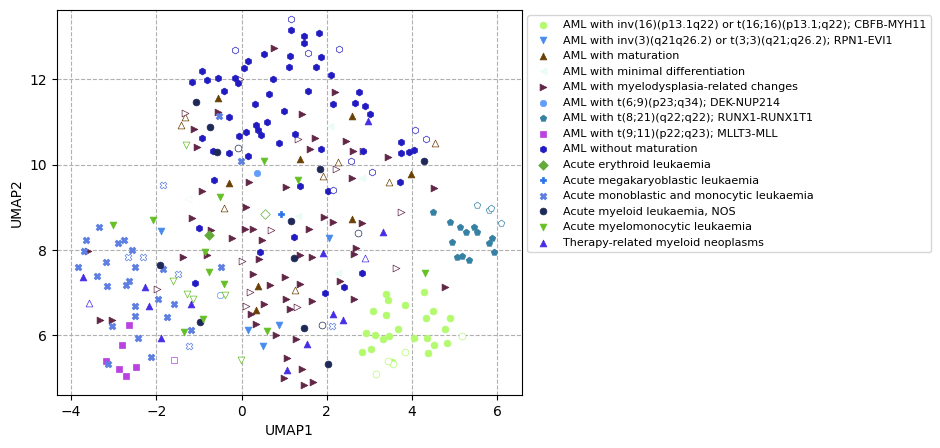

In [8]:
plotting.plot_umap(X_tr_umap, X_tst_umap, Y_train, Y_test, labels, s = 24)

## II. Création d'un réseau de neurones artificiel pour un problème de régression avec un auto-encodeur. 
### II.1 Créez une fonction qui construit un modèle DNN selon la structure <code>encoder => bottleneck => decoder</code>


In [9]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables

In [10]:
mm,encoder  = engines.auto_encoder(insize, insize, 2)
encoder(X_train).shape
mm.parameters()

<generator object Module.parameters at 0x7fa1b71750e0>

### II.2 Lancez un entrainement de 1000 epochs et enregistrez la performance du modèle par epoch sous la forme de l'erreur et la correlation de Pearson sur l'ensemble de test et de train.

In [11]:
mm, trl, tstl, trc, tstc  = engines.train_auto_encoder(insize, 2, X_train, X_test, nepochs = 300, lr = 5 * 1e-4)


Loss 0 Train - loss : 1.22 - acc : -0.01 Test acc : -0.01
Loss 10 Train - loss : 1.13 - acc : 0.14 Test acc : 0.14
Loss 20 Train - loss : 1.01 - acc : 0.24 Test acc : 0.24
Loss 30 Train - loss : 0.71 - acc : 0.45 Test acc : 0.45
Loss 40 Train - loss : 0.31 - acc : 0.73 Test acc : 0.73
Loss 50 Train - loss : 0.11 - acc : 0.9 Test acc : 0.9
Loss 60 Train - loss : 0.07 - acc : 0.94 Test acc : 0.94
Loss 70 Train - loss : 0.05 - acc : 0.95 Test acc : 0.95
Loss 80 Train - loss : 0.05 - acc : 0.96 Test acc : 0.96
Loss 90 Train - loss : 0.05 - acc : 0.96 Test acc : 0.96
Loss 100 Train - loss : 0.05 - acc : 0.96 Test acc : 0.96
Loss 110 Train - loss : 0.05 - acc : 0.96 Test acc : 0.96
Loss 120 Train - loss : 0.05 - acc : 0.96 Test acc : 0.96
Loss 130 Train - loss : 0.05 - acc : 0.96 Test acc : 0.96
Loss 140 Train - loss : 0.05 - acc : 0.96 Test acc : 0.96
Loss 150 Train - loss : 0.05 - acc : 0.96 Test acc : 0.96
Loss 160 Train - loss : 0.05 - acc : 0.96 Test acc : 0.96
Loss 170 Train - loss : 0

### II.3 Produisez la courbe d'apprentissage de l'entrainement de ce réseau, c'est à dire la courbe de l'erreur sur le test et le train et la corrélation de Pearson selon les epochs. 

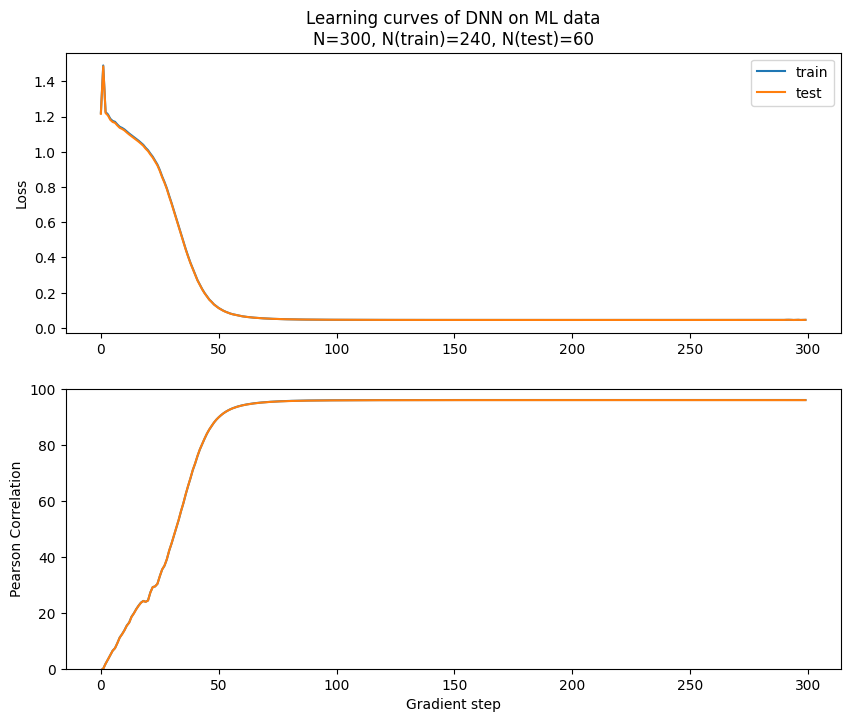

In [12]:
plotting.plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test)

### II.4 Faites la visualisation de la corrélation sur les données de test prédites et vraies. <u>Rapportez votre résultat sous la forme d'un histogramme 2D avec des hexagones, l'échelle de la densité doit être rapportées.

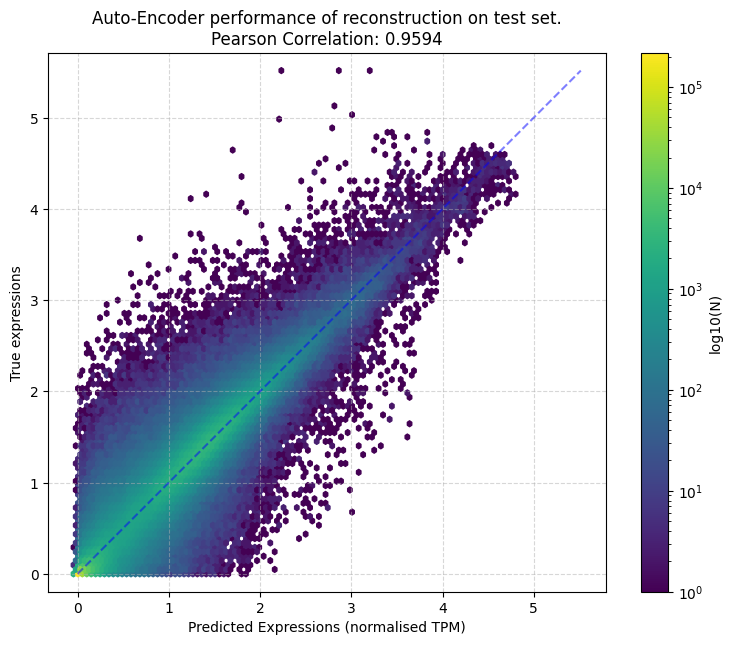

In [13]:
plotting.plot_ae_performance(mm, X_test, dataset = datasetname)
    

## III. Variational Auto-Encoders (VAE) pour un gain de performance de reconstruction dans les problèmes de régression. (seance 2)

In [14]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train,  Y_test = train_test_split(torch.Tensor(tpm_data.T), torch.Tensor(Y),test_size=0.2)
insize = X_train.shape[1] ## some model setting variables

In [15]:
mm = engines.VariationalAutoencoder(insize, 2)

In [16]:
mm(X_train)

tensor([[ 0.0052,  0.2093, -0.0795,  ..., -0.0712, -0.2483, -0.0266],
        [ 0.0300, -0.0653, -0.4740,  ..., -0.0691, -0.3061, -0.0990],
        [ 0.0355,  0.2331, -0.0854,  ..., -0.0727, -0.2644, -0.0778],
        ...,
        [ 0.0365, -0.0337, -0.8583,  ..., -0.0849, -0.3946, -0.1037],
        [ 0.0788,  0.0632, -0.9104,  ..., -0.1048, -0.4666, -0.0137],
        [ 0.3278,  0.2045, -1.3932,  ..., -0.0851, -0.4883, -0.0354]],
       grad_fn=<AddmmBackward0>)

In [17]:
VAE, trl, tstl, trc, tstc = engines.train_variational_auto_encoder(insize, 125, X_train, X_test, nepochs = 300, printstep = 10, wd = 1e-3, lr = 0.0001)

Loss 0 Train - loss : 1.28 - acc : -0.0 Test acc : -0.0
Loss 10 Train - loss : 1.21 - acc : 0.02 Test acc : 0.02
Loss 20 Train - loss : 1.19 - acc : 0.05 Test acc : 0.05
Loss 30 Train - loss : 1.17 - acc : 0.08 Test acc : 0.08
Loss 40 Train - loss : 1.16 - acc : 0.11 Test acc : 0.11
Loss 50 Train - loss : 1.14 - acc : 0.14 Test acc : 0.14
Loss 60 Train - loss : 1.13 - acc : 0.16 Test acc : 0.16
Loss 70 Train - loss : 1.1 - acc : 0.19 Test acc : 0.19
Loss 80 Train - loss : 1.07 - acc : 0.21 Test acc : 0.21
Loss 90 Train - loss : 1.0 - acc : 0.26 Test acc : 0.26
Loss 100 Train - loss : 0.9 - acc : 0.33 Test acc : 0.33
Loss 110 Train - loss : 0.77 - acc : 0.41 Test acc : 0.41
Loss 120 Train - loss : 0.62 - acc : 0.51 Test acc : 0.51
Loss 130 Train - loss : 0.48 - acc : 0.61 Test acc : 0.6
Loss 140 Train - loss : 0.36 - acc : 0.7 Test acc : 0.7
Loss 150 Train - loss : 0.26 - acc : 0.77 Test acc : 0.77
Loss 160 Train - loss : 0.19 - acc : 0.83 Test acc : 0.83
Loss 170 Train - loss : 0.14 - 

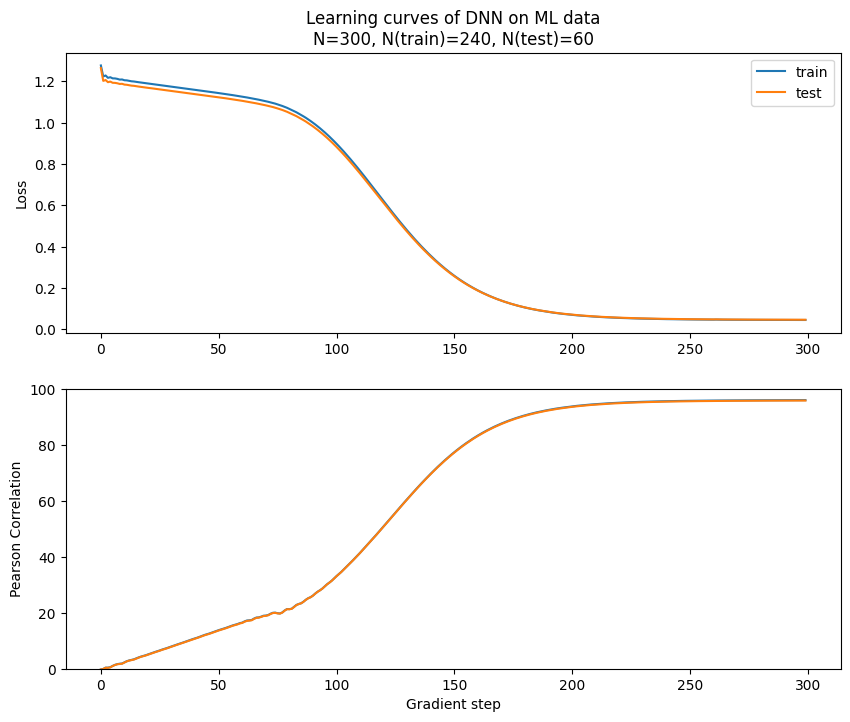

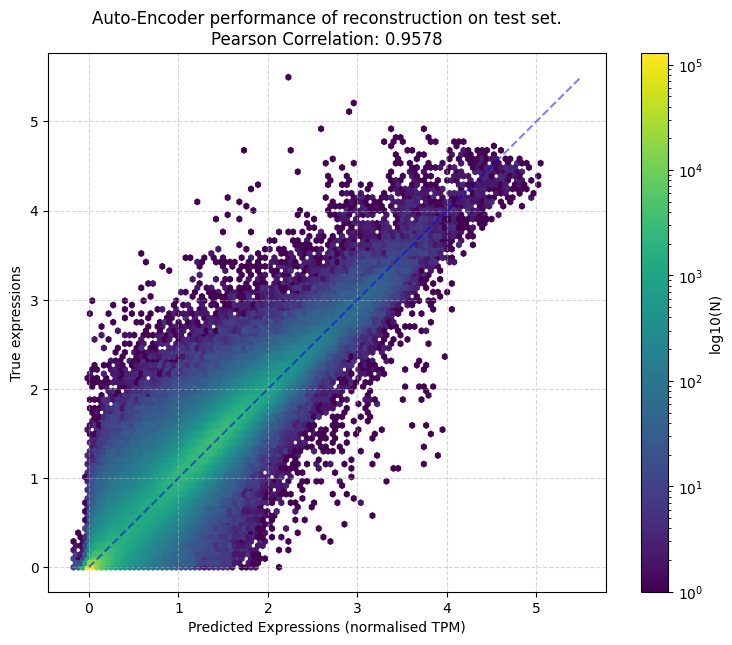

In [18]:
plotting.plot_learning_curves(trl, tstl, trc, tstc, tpm_data, X_train, X_test)
plotting.plot_ae_performance(VAE, X_test, modeltype ="VAE", dataset = datasetname)

## IV. UMAP supervise

In [25]:
lblenc = LabelEncoder()
lblenc.fit(labels)
Y = lblenc.transform(labels)
X_train, X_test, Y_train, Y_test = train_test_split(tpm_data.T, Y, test_size = 0.2)
mapper = umap.UMAP(verbose = 1, n_components = 2, min_dist=1., 
    n_neighbors =10, n_epochs = 1000).fit(X_train,  y = Y_train)

UMAP(min_dist=1.0, n_epochs=1000, n_neighbors=10, verbose=1)
Wed Dec  6 18:11:29 2023 Construct fuzzy simplicial set
Wed Dec  6 18:11:29 2023 Finding Nearest Neighbors
Wed Dec  6 18:11:29 2023 Finished Nearest Neighbor Search
Wed Dec  6 18:11:29 2023 Construct embedding


Epochs completed:  73%| ███████▎   728/1000 [00:01]

	completed  0  /  1000 epochs
	completed  100  /  1000 epochs
	completed  200  /  1000 epochs
	completed  300  /  1000 epochs
	completed  400  /  1000 epochs
	completed  500  /  1000 epochs
	completed  600  /  1000 epochs
	completed  700  /  1000 epochs


Epochs completed: 100%| ██████████ 1000/1000 [00:01]


	completed  800  /  1000 epochs
	completed  900  /  1000 epochs
Wed Dec  6 18:11:31 2023 Finished embedding


In [26]:
X_tr_umap = mapper.transform(X_train)
X_tst_umap = mapper.transform(X_test)

Epochs completed: 100%| ██████████ 333/333 [00:01]

	completed  0  /  333 epochs
	completed  33  /  333 epochs
	completed  66  /  333 epochs
	completed  99  /  333 epochs
	completed  132  /  333 epochs
	completed  165  /  333 epochs
	completed  198  /  333 epochs
	completed  231  /  333 epochs
	completed  264  /  333 epochs
	completed  297  /  333 epochs
	completed  330  /  333 epochs


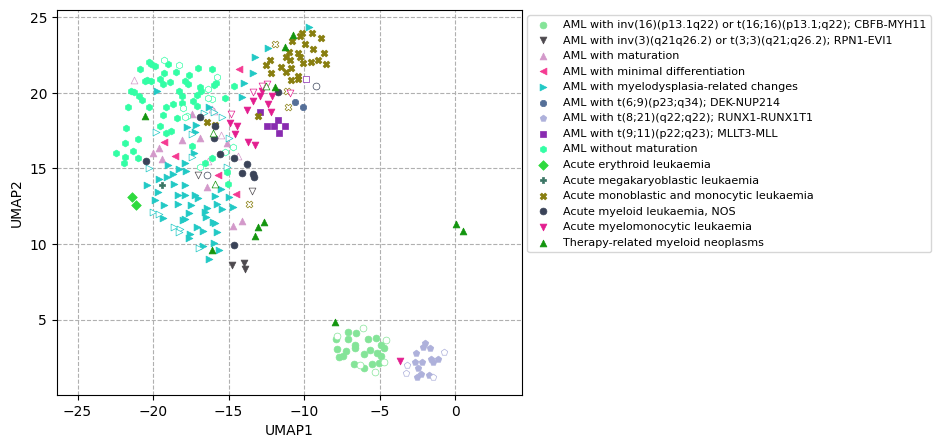

In [27]:
plotting.plot_umap(X_tr_umap, X_tst_umap, lblenc.inverse_transform(Y_train), lblenc.inverse_transform(Y_test), labels, s = 24)

## V. Auto-Encodeur Lineaire vs PCA 

In [28]:
datasetname = "BRCA"
tpm_data = datasets[datasetname].data
genes = datasets[datasetname].genes
labels = datasets[datasetname].labels
samples = datasets[datasetname].samples

In [38]:
lblbin = LabelBinarizer()
Y = torch.Tensor(lblbin.fit_transform(labels))
X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(tpm_data.T), Y, test_size = 0.2)
insize = X_train.shape[1]

In [63]:
### fonction d'initialisation du reseau
def linear_auto_encoder(insize, outsize, bnsize, width=100):
    model = nn.Sequential(
    nn.Linear(insize,width, bias = False),
    nn.Linear(width, width, bias = False),
    nn.Linear(width, bnsize, bias = False), 
    nn.Linear(bnsize, width, bias = False),
    nn.Linear(width, outsize, bias = False))
    return model, model[0:3]


def train_linear_auto_encoder(insize, bnsize, X_train, X_test, nepochs = 100, printstep=10, wd = 1e-3, lr = 0.0001):
    DNN, encoder = linear_auto_encoder(insize, insize, bnsize )
    optimizer = torch.optim.Adam(DNN.parameters(), lr = lr)
    tr_losses, tst_losses, tr_accs, tst_accs = [],[],[],[]
    for i in range(nepochs):
        optimizer.zero_grad() # required
        y_tr_out = DNN(X_train) # feed forward
        y_tst_out = DNN(X_test)
        tr_loss = nn.functional.mse_loss(y_tr_out, X_train) # loss computation
        tst_loss = nn.functional.mse_loss(y_tst_out, X_test) # Softmax -> NLL
        
        tr_acc = pearsonr(y_tr_out.flatten().detach().numpy(), X_train.flatten().detach().numpy()).statistic # Pearson corr. coeff
        tst_acc = pearsonr(y_tst_out.flatten().detach().numpy(), X_test.flatten().detach().numpy()).statistic
            
        if i % printstep == 0 or i+1 == nepochs :
            print(f"Loss {i} Train - loss : {round(float(tr_loss),3)} - acc : {round(float(tr_acc),3)} Test acc : {round(tst_acc,3)}")
        tr_loss.backward() # back prop
        optimizer.step() # optimizer update
        [tr_losses.append(float(tr_loss)), tst_losses.append(float(tst_loss)), tr_accs.append(tr_acc), tst_accs.append(tst_acc)]
    return DNN, np.array(tr_losses), np.array(tst_losses), np.array(tr_accs), np.array(tst_accs)


In [64]:
LAE, trl, tstl, trc, tstc = train_linear_auto_encoder(insize, 2, X_train, X_test, lr = 1e-3)

Loss 0 Train - loss : 0.148 - acc : -0.001 Test acc : -0.0
Loss 10 Train - loss : 0.596 - acc : -0.027 Test acc : -0.028
Loss 20 Train - loss : 0.217 - acc : 0.002 Test acc : 0.003
Loss 30 Train - loss : 0.103 - acc : 0.194 Test acc : 0.196
Loss 40 Train - loss : 0.06 - acc : 0.376 Test acc : 0.38
Loss 50 Train - loss : 0.036 - acc : 0.568 Test acc : 0.575
Loss 60 Train - loss : 0.029 - acc : 0.624 Test acc : 0.633
Loss 70 Train - loss : 0.027 - acc : 0.645 Test acc : 0.653
Loss 80 Train - loss : 0.026 - acc : 0.655 Test acc : 0.663
Loss 90 Train - loss : 0.026 - acc : 0.659 Test acc : 0.667
Loss 99 Train - loss : 0.026 - acc : 0.66 Test acc : 0.668


In [65]:
LAE_X_train = LAE[0:3](X_train).detach().numpy()
LAE_X_test = LAE[0:3](X_test).detach().numpy()

In [66]:
pca = PCA(n_components=2)
pca.fit(X_train)
PCA_X_train = pca.transform(X_train)
PCA_X_test = pca.transform(X_test)

In [70]:
y_tr_labs = lblbin.inverse_transform(Y_train.detach().numpy())
y_tst_labs = lblbin.inverse_transform(Y_test.detach().numpy())

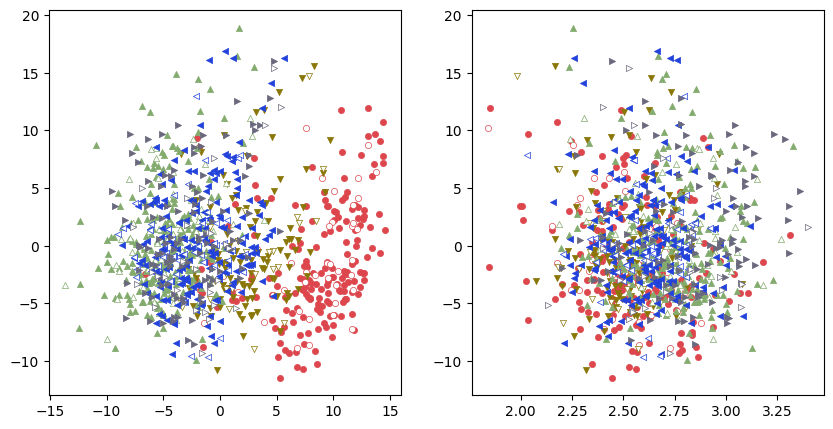

In [76]:
def random_color_generator():
    r = random.randint(0, 255)/256
    g = random.randint(0, 255)/256
    b = random.randint(0, 255)/256
    return (r, g, b)
# comparison 
fig, axes = plt.subplots(ncols = 2, figsize = (10,5))
s = 20
markers_ = np.concatenate([['o',"v","^","<",">","8","p","s","h","D","P","X"] for i in range(10)])
colors_by_ctype = [random_color_generator() for  i in range(len(np.unique(labels)))]
for (i,lbl) in enumerate(np.unique(labels)):
    axes[0].scatter(PCA_X_train[y_tr_labs ==lbl,0], 
                PCA_X_train[y_tr_labs ==lbl,1], 
                s = s, color = colors_by_ctype[i], linewidth = 0.5, marker=markers_[i], label = lbl)
    axes[0].scatter(PCA_X_test[ y_tst_labs ==lbl,0], 
            PCA_X_test[y_tst_labs==lbl,1], 
            s = s, edgecolors = colors_by_ctype[i], color ="white", linewidth = 0.5, marker=markers_[i])
    axes[1].scatter(LAE_X_train[y_tr_labs ==lbl,0], 
                PCA_X_train[y_tr_labs ==lbl,1], 
                s = s, color = colors_by_ctype[i], linewidth = 0.5, marker=markers_[i], label = lbl)
    axes[1].scatter(LAE_X_test[ y_tst_labs ==lbl,0], 
            PCA_X_test[y_tst_labs==lbl,1], 
            s = s, edgecolors = colors_by_ctype[i], color ="white", linewidth = 0.5, marker=markers_[i])

## VI. Introduction au benchmarking, comparaison de methodes